# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Wednesday, March 22, 11:59pm**


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kennyjhcheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "Mount Everests",
    "Raspberry",
    "Mount Denali",
    "Arithmetic",
    "Topology",
    "Baseball",
    "Hockey",
    "Mango_fruit",
    "Mount Kenya",
    "Football"
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location', and λόγος, 'study') is concerned with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",68
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22


**ANSWER:**

I would select 4 clusters based on the queries

1. Mountains: `Mount Denali`, `Mount Kenya`, `Mount Everests`
2. Fruit: `Raspberry`, `Mango_fruit`
3. Sports: `Baseball`, `Hockey`, `Football`
4. Field of study: `Arithmetic`, `Topology`

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:10}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from question 1.1 using a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in question 1.1. Examine clustering labels assigned by `KMeans`.
2. Repeat after modifying the `CountVectorizer` to ignore words appearing in only one sentence (or document, one row of `wiki_df`).
3. Keeping the new `CountVectorizer`, examine clustering labels assigned by `KMeans` under an off-by-1 value of K.
4. Briefly describe and analyze the behavoir of `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)
bow_df

,048,10,18,190,20,24,310,46,addition,africa,...,winter,words,zhūmùlǎngmǎ,λόγος,τέχνη,τική,τόπος,सगरम,ἀριθμός,珠穆朗玛峰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Question 1
kmeans = KMeans(n_clusters=4)
kmeans.fit(bow_sents)

pd.DataFrame({"label":kmeans.labels_}, index=wiki_df.index)


,label
0,0
1,0
2,0
3,3
4,2
5,1
6,0
7,0
8,0
9,0


In [6]:
def print_cluster_assignments(kmeans, num_clusters):
    labels = kmeans.labels_
    clusters = {}
    for i in range(num_clusters):
        clusters[str(i)] = []

    for i, label in enumerate(labels):
        clusters[str(label)].append(queries[i])
    for i in clusters.items():
        print(i)
print_cluster_assignments(kmeans, 4)

('0', ['Mount Everests', 'Raspberry', 'Mount Denali', 'Hockey', 'Mango_fruit', 'Mount Kenya', 'Football'])
('1', ['Baseball'])
('2', ['Topology'])
('3', ['Arithmetic'])


In [7]:
# Question 2
vec_ignore_one = CountVectorizer(stop_words='english', min_df=2)
bow_sents_ignore_one = vec_ignore_one.fit_transform(wiki_df["text"]).todense()
bow_df_ignore_one = pd.DataFrame(
    data=bow_sents_ignore_one, columns=vec_ignore_one.get_feature_names_out(), index=wiki_df.index
)
bow_df

,048,10,18,190,20,24,310,46,addition,africa,...,winter,words,zhūmùlǎngmǎ,λόγος,τέχνη,τική,τόπος,सगरम,ἀριθμός,珠穆朗玛峰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
kmeans_ignore_one = KMeans(n_clusters=4)
kmeans_ignore_one.fit(bow_sents_ignore_one)

pd.DataFrame({"label":kmeans_ignore_one.labels_}, index=wiki_df.index)

,label
0,1
1,0
2,1
3,2
4,2
5,3
6,3
7,0
8,1
9,3


In [9]:
print_cluster_assignments(kmeans_ignore_one, 4)

('0', ['Raspberry', 'Mango_fruit'])
('1', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('2', ['Arithmetic', 'Topology'])
('3', ['Baseball', 'Hockey', 'Football'])


In [10]:
# Question 3
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(bow_sents_ignore_one)
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(bow_sents_ignore_one)

print("Cluster assignments for k=3")
print_cluster_assignments(kmeans_3, 3)
print("Cluster assignments for k=5")
print_cluster_assignments(kmeans_5, 5)


Cluster assignments for k=3
('0', ['Raspberry', 'Baseball', 'Hockey', 'Mango_fruit', 'Football'])
('1', ['Arithmetic', 'Topology'])
('2', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
Cluster assignments for k=5
('0', ['Hockey', 'Football'])
('1', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('2', ['Arithmetic', 'Topology'])
('3', ['Raspberry', 'Mango_fruit'])
('4', ['Baseball'])


#### Question 4
**ANSWER:**

`KMeans` does a good job of clustering when we ignore words in `CountVectorizer` that are only in one dataset. In fact, it clusters the queries exactly the same as how I manually classified them. However, without removing words that are only in one dataset, it does an extremely poor job of clustering from what's expected.

When we decrease the number of clusters to `k = 3`, the clustering becomes quite incomprehensible again, with one cluster containing mountains, fruits, sports, and a field of study.

When raising the number of clusters to `k = 5`, the clusters also become less sensible. Although the mountains are all clustered together, fields of study, fruits, and sports are clustered together or by themselves.

<br><br>

### 1.3 Sentence embedding representation
rubric={points:10}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this lab. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [11]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [12]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.532167,0.219127,0.029919,-0.407121,-0.616050,0.339105,-0.369831,-0.268620,0.284335,0.154874,...,0.049630,-0.063532,0.193070,0.345019,0.111516,-0.018490,0.062621,-0.105441,0.084189,0.097068
1,-0.257144,0.279161,0.222628,0.190509,0.057312,0.215431,0.124740,0.256541,-0.093520,0.304061,...,-0.350746,-0.103448,0.188898,0.002680,0.364525,0.270561,0.617305,0.565283,0.068011,0.210108
2,-0.153511,0.308003,0.042989,-0.000984,-0.228809,0.145077,-0.189960,0.006522,0.346580,0.009805,...,0.345482,0.149472,-0.128204,0.069986,-0.049316,-0.122243,-0.520354,0.052404,0.277886,-0.082411
3,-0.182560,0.174977,-0.142932,0.508398,-0.102793,0.314821,-0.028197,0.235509,0.293719,0.091492,...,0.153091,-0.220330,0.126606,0.091785,0.087272,0.279831,-0.328509,0.157604,0.439283,0.204193
4,0.002731,0.032420,0.043655,0.501373,0.442546,0.157427,0.082318,0.287892,0.322357,0.356958,...,0.267656,-0.337920,0.343273,0.429253,-0.042079,0.466611,-0.574508,0.004958,0.390041,0.150982
5,-0.042878,0.029168,-0.187499,-0.020230,-0.260429,-0.120475,0.067830,0.296153,-0.020178,0.003125,...,0.178184,-0.003942,0.331448,-0.395468,0.025013,0.082307,-0.561699,0.560587,0.141633,-0.373937
6,-0.071380,0.096587,0.055705,-0.525645,0.580350,0.096592,0.441484,0.257061,-0.054260,0.220842,...,0.457613,-0.331446,-0.066380,-0.019426,-0.147649,0.034530,-0.095109,0.304422,0.327636,-0.197770
7,-0.141320,0.030474,0.261100,-0.219024,-0.277812,0.177240,0.191265,0.252725,-0.035201,0.198338,...,0.104466,-0.177960,0.088618,0.289035,-0.089657,0.246048,-0.060229,0.500508,-0.045897,-0.046336
8,-0.291509,0.554150,0.115631,-0.188634,-0.074476,-0.277101,-0.000275,0.076826,0.199134,0.033996,...,0.055575,0.047854,0.214838,-0.086142,0.453633,0.021888,-0.143639,0.167839,-0.151438,-0.076444
9,-0.071756,0.133156,-0.071761,0.306060,0.358961,-0.061443,0.167584,0.364614,0.323541,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881


#### Question 1
**ANSWER:**

There are `768` dimensions in this representations

In [13]:
# Question 2
kmeans_sen_embs = {}
for i in range(3, 6):
    kmeans_sen_emb = KMeans(n_clusters=i)
    kmeans_sen_emb.fit(emb_sents)
    kmeans_sen_embs[i] = kmeans_sen_emb
    print(f"\nCluster assignments for k={i}")
    print_cluster_assignments(kmeans_sen_emb, i)


Cluster assignments for k=3
('0', ['Raspberry', 'Mango_fruit'])
('1', ['Arithmetic', 'Topology', 'Baseball', 'Hockey', 'Football'])
('2', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])

Cluster assignments for k=4
('0', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('1', ['Baseball', 'Hockey', 'Football'])
('2', ['Raspberry', 'Mango_fruit'])
('3', ['Arithmetic', 'Topology'])

Cluster assignments for k=5
('0', ['Arithmetic', 'Topology'])
('1', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('2', ['Hockey'])
('3', ['Raspberry', 'Mango_fruit'])
('4', ['Baseball', 'Football'])


#### Question 3
**ANSWER:**

The clusters using `SentneceTransformer` and `KMeans` are clustered better than using `CountVectorizer`. Their performance is identical when we choose `k=4`, however for `k=3` and `k=5`, the sentence embedding representation of our data produces more sensible clusters.

For `k=3`, the fields of study and mountains are grouped together. The fruits and sports are all placed into one group.

For `k=5`, clusters `1-4` all contains queries that fit into their clusters. The extra cluster `0` contains `Hockey` which `KMeans` has deemed most dissimilar to the other sports so it belongs in its own cluster, maybe because it doesn't use a ball. These clusters are all sensible.

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:10}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_cosine_distances.html).*

In [14]:
from sklearn.metrics.pairwise import paired_cosine_distances

In [15]:
distances = []
for i in range(10):
    distances.append(paired_cosine_distances(np.array(([emb_sents[i]] * 10)), emb_sents))

cos_dist_df = pd.DataFrame(distances)
cos_dist_df

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.931335,0.424351,0.827909,0.870119,0.925507,0.951119,0.841844,0.409439,0.991959
1,0.931335,0.000000,0.906466,0.847008,0.864609,0.869627,0.903234,0.522127,0.898712,0.839252
2,0.424351,0.906466,0.000000,0.907096,0.854795,0.856470,0.815634,0.853448,0.456956,0.904455
3,0.827909,0.847008,0.907096,0.000000,0.381103,0.772545,0.812594,0.902332,0.889986,0.816896
4,0.870119,0.864609,0.854795,0.381103,0.000000,0.755116,0.753566,0.842974,0.955045,0.792475
5,0.925507,0.869627,0.856470,0.772545,0.755116,0.000000,0.596294,0.951435,0.831017,0.528304
6,0.951119,0.903234,0.815634,0.812594,0.753566,0.596294,0.000000,0.916050,0.954532,0.526190
7,0.841844,0.522127,0.853448,0.902332,0.842974,0.951435,0.916050,0.000000,0.806186,0.845019
8,0.409439,0.898712,0.456956,0.889986,0.955045,0.831017,0.954532,0.806186,0.000000,0.938582
9,0.991959,0.839252,0.904455,0.816896,0.792475,0.528304,0.526190,0.845019,0.938582,0.000000


In [16]:
print(cos_dist_df[cos_dist_df > 0].min().min())
print(cos_dist_df.max().max())

0.38110328
0.991959


In [17]:

# Question 1

min_samples_vs_eps = {
    x: [] for x in (np.arange(1, 11) / 10)
}
min_samples_vs_eps["min_samples"] = np.arange(1, 11)

for i in min_samples_vs_eps["min_samples"]:
    for j in (np.arange(1, 11) / 10):
        dbscan = DBSCAN(eps=j, min_samples=i, metric='cosine')
        dbscan.fit(emb_sents)
        min_samples_vs_eps[j].append(len(np.unique(dbscan.labels_)))



In [18]:
pd.DataFrame(min_samples_vs_eps)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,min_samples
0,10,10,10,9,7,4,4,3,1,1,1
1,1,1,1,2,3,4,4,3,1,1,2
2,1,1,1,1,2,3,3,3,1,1,3
3,1,1,1,1,1,1,1,2,1,1,4
4,1,1,1,1,1,1,1,2,1,1,5
5,1,1,1,1,1,1,1,1,1,1,6
6,1,1,1,1,1,1,1,1,1,1,7
7,1,1,1,1,1,1,1,1,1,1,8
8,1,1,1,1,1,1,1,1,2,1,9
9,1,1,1,1,1,1,1,1,1,1,10


In [19]:
print("min_samples = 1")
for i in range(1, 11):
    dbscan = DBSCAN(eps=i/10, min_samples=1, metric='cosine')
    dbscan.fit(emb_sents)
    print(f'eps={i}: {np.unique(dbscan.labels_)}')
print("\nmin_samples = 2")
for i in range(1, 11):
    dbscan = DBSCAN(eps=i/10, min_samples=2, metric='cosine')
    dbscan.fit(emb_sents)
    print(f'eps={i}: {np.unique(dbscan.labels_)}')

min_samples = 1
eps=1: [0 1 2 3 4 5 6 7 8 9]
eps=2: [0 1 2 3 4 5 6 7 8 9]
eps=3: [0 1 2 3 4 5 6 7 8 9]
eps=4: [0 1 2 3 4 5 6 7 8]
eps=5: [0 1 2 3 4 5 6]
eps=6: [0 1 2 3]
eps=7: [0 1 2 3]
eps=8: [0 1 2]
eps=9: [0]
eps=10: [0]

min_samples = 2
eps=1: [-1]
eps=2: [-1]
eps=3: [-1]
eps=4: [-1  0]
eps=5: [-1  0  1]
eps=6: [0 1 2 3]
eps=7: [0 1 2 3]
eps=8: [0 1 2]
eps=9: [0]
eps=10: [0]


In [20]:
dbscan6 = DBSCAN(eps=0.6, min_samples=2, metric='cosine')
dbscan6.fit(emb_sents)
print(f'eps=6: {dbscan6.labels_}')
dbscan7 = DBSCAN(eps=0.7, min_samples=2, metric='cosine')
dbscan7.fit(emb_sents)
print(f'eps=7: {dbscan7.labels_}')

eps=6: [0 1 0 2 2 3 3 1 0 3]
eps=7: [0 1 0 2 2 3 3 1 0 3]


In [21]:
print_cluster_assignments(dbscan6, 4)
print('\n')
print_cluster_assignments(dbscan7, 4)

('0', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('1', ['Raspberry', 'Mango_fruit'])
('2', ['Arithmetic', 'Topology'])
('3', ['Baseball', 'Hockey', 'Football'])


('0', ['Mount Everests', 'Mount Denali', 'Mount Kenya'])
('1', ['Raspberry', 'Mango_fruit'])
('2', ['Arithmetic', 'Topology'])
('3', ['Baseball', 'Hockey', 'Football'])


#### Question 2
**ANSWER:**

By analyzing the `cosine_distance`s and tuning `min_samples` and `eps`, `DBSCAN` is able to identify `4` clusters with assignments corresponding to my manual assignment. However, I was only able to tune and identify the best hyperparameters because of pre-existing knowledge of the number of clusters and assignments assuming my manual clustering is a correct interpretation.

In my dataframe comparing `min_samples_vs_eps`, a `min_samples` from `1-3` could have been chosen, or `eps` from `0.5-0.8` may have been reasonable choices given no pre-existing knowledge on number of clusters.

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [22]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

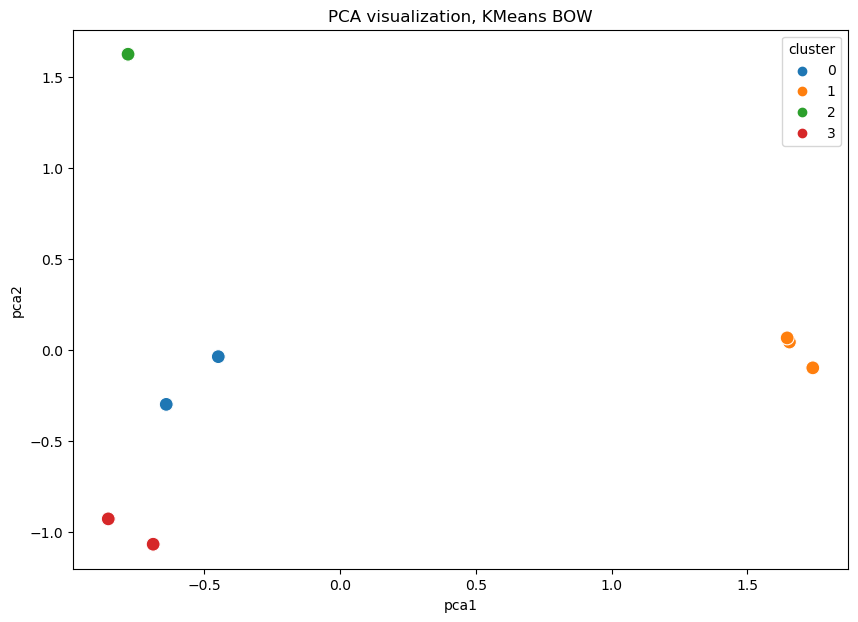

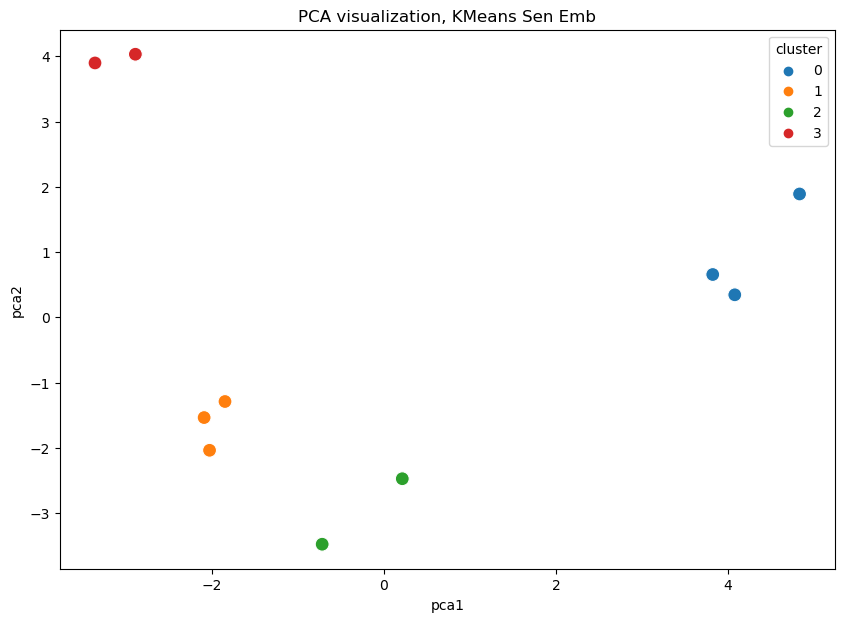

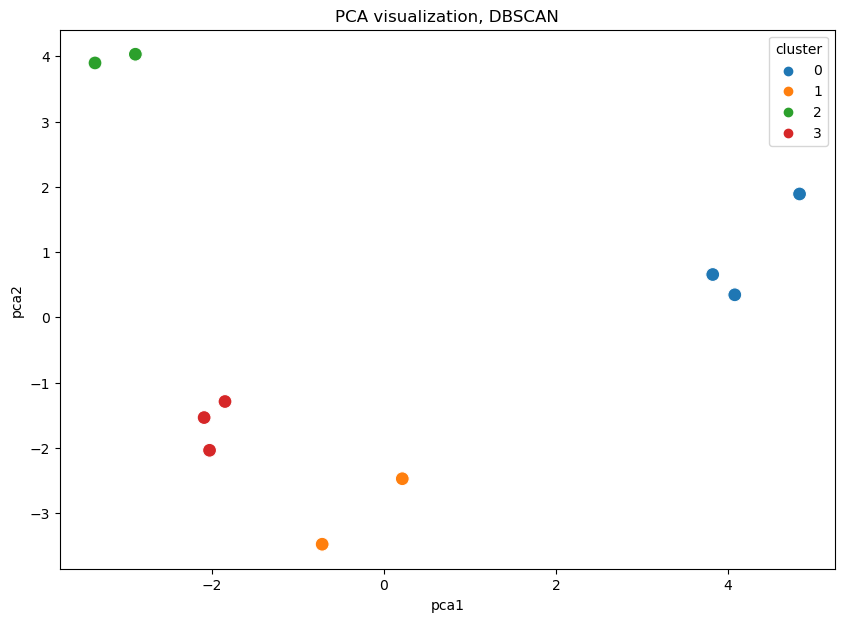

In [23]:
plot_pca_clusters(
    bow_sents_ignore_one,
    kmeans_ignore_one.labels_,
    title="PCA visualization, KMeans BOW"
)

plot_pca_clusters(
    emb_sents,
    kmeans_sen_embs[4].labels_,
    title="PCA visualization, KMeans Sen Emb"
)

plot_pca_clusters(
    emb_sents,
    dbscan6.labels_,
    title="PCA visualization, DBSCAN"
)

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [24]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [25]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:6}

Here is some notation we will be using in this lab. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 - $k$: the number of latent dimensions we use in collaborative filtering
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - $Z$: a matrix whose rows $z_m$ represent the features for movie $m$ (size $M\times d$).
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of observed ratings in the utility matrix $Y$? 

In [26]:
ratings.shape

(100000, 4)

In [27]:
print(f"unique users: {len(np.unique(ratings.user_id))}")
print(f"unique movies: {len(np.unique(ratings.movie_id))}")

unique users: 943
unique movies: 1682


In [28]:
N = 943
M = 1682
Y_shape = (943, 1682)
Y_frac_observed = ratings.shape[0]/(943 * 1682)
Y_frac_observed

0.06304669364224531

**ANSWERS:**

1. `N=943` and `M=1682` for each unique user and movie respectivley
2. Shape of `Y=(943, 1682)`, a row for each user, and column for each movie
3. Fraction of observed ratings in `Y` is `0.063` or `6.3%`

<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

X shape: (100000, 4)
y shape: (100000,)
X_train shape: (80000, 4)
X_valid shape: (20000, 4)
y_train shape: (80000,)
y_valid shape: (20000,)


<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**

1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [32]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [33]:
# From CPSC 330 Lec 15
def create_Y_from_ratings(
    data, N, M, user_mapper, item_mapper, user_key="user_id", item_key="movie_id"
):  # Function to create a dense utility matrix
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [34]:
# Question 1
train_mat = create_Y_from_ratings(X_train, N, M, user_mapper, item_mapper)
valid_mat = create_Y_from_ratings(X_valid, N, M, user_mapper, item_mapper)

In [35]:
np.count_nonzero(~np.isnan(train_mat)), np.count_nonzero(~np.isnan(valid_mat))


(80000, 20000)

In [36]:
train_mat.shape, valid_mat.shape

((943, 1682), (943, 1682))

#### Question 2
**ANSWER:**

The training and validation utility matrices have the same shape because they both have a row for every user and column for every movie. However, the observed ratings in the training utility matrix are from the training set, and similarly for validation set. This means the fraction of observed ratings is greater in the training set with `0.8` split than validation set `0.2` split.

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [37]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

#### Question 1

**ANSWER:**

1. To evaluate recommender systems, we are comparing the `RMSE` between the actual ratings, and predicted ratings after the utility matrix has been filled in (ignoring `nan` that appear when one of the matrices has no rating in the corresponding cell). 
2. The global average baseline `train RMSE = 1.13` and `validation RMSE = 1.12`

In [38]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [39]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

In [40]:
from sklearn.impute import KNNImputer

In [41]:
train_mat_copy = np.copy(train_mat)

In [42]:
imputer = KNNImputer(n_neighbors=10, copy=False)
imputer.fit_transform(train_mat_copy)

array([[4. , 3. , 4. , ..., 3. , 2. , 3. ],
       [4. , 3. , 3.3, ..., 3. , 2. , 3. ],
       [3.8, 3.2, 2.8, ..., 3. , 2. , 3. ],
       ...,
       [5. , 3.4, 2.9, ..., 3. , 2. , 3. ],
       [4.2, 3.4, 3.6, ..., 3. , 2. , 3. ],
       [4.3, 5. , 3.2, ..., 3. , 2. , 3. ]])

In [43]:
train_mat.shape, train_mat_copy.shape

((943, 1682), (943, 1682))

In [44]:
pd.DataFrame(train_mat_copy).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,4.0,3.0,4.0,3.7,3.0,3.8,4.0,3.3,5.0,3.0,...,3.0,NaN,NaN,2.0,NaN,1.0,3.0,2.0,3.0,NaN
1,4.0,3.0,3.3,4.1,3.2,4.3,4.4,4.4,4.5,4.1,...,3.0,NaN,NaN,2.0,NaN,1.0,3.0,2.0,3.0,NaN
2,3.8,3.2,2.8,3.1,3.5,3.5,4.0,3.7,3.7,4.3,...,3.0,NaN,NaN,2.0,NaN,1.0,3.0,2.0,3.0,NaN
3,4.1,2.9,3.9,3.1,3.6,3.8,3.3,4.3,4.2,4.2,...,3.0,NaN,NaN,2.0,NaN,1.0,3.0,2.0,3.0,NaN
4,4.0,3.0,3.3,3.8,3.3,4.1,4.0,3.8,3.8,4.1,...,3.0,NaN,NaN,2.0,NaN,1.0,3.0,2.0,3.0,NaN


In [45]:
evaluate(train_mat_copy, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 0.98


**ANSWER:**

KNN imputation has a perfect training error, this is expected because the user ratings are still preserved and `KNNImputer` fills in the ratings that were `nan`, not provided by the user.

The validation error of `KNNImputer` is a bit better than the global vaverage, but not by a lot.

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [46]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

In [47]:
ratings_svd = ratings.drop(columns=['timestamp'])

In [48]:
# From CSPC 330 lecture 15
reader = Reader()
data = Dataset.load_from_df(ratings_svd, reader)  # Load the data

trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  

k = 10
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 0.9328


0.932839700199596

**ANSWER:**
The global average baseline validation `RMSE=1.12`, the `KNNImputer` baseline validation `RMSE=0.98` and the collaborative filtering `RMSE=0.9328`. Although we do see an improvement, it is not a major improvement from the global average baseline and only a tiny improvement from `KNNImputer`.

<br><br>

### 2.7 Clustering based recommendation system?
rubric={points:2}

How would you apply `K-Means` clustering to build a recommendation systems? What could be challenging with this approach?

**ANSWER:**

For each user, I would 

1. cluster the items that the user rated highly (e.g. above `3.5`) to find clusters of item types that the user likes. 
    - I would not cluster every item rated by the user, because then clusters could contain both highly rated, and low rated items. 
2. Then I would predict how much a user likes other items by calculating the similarity measure of new items to the cluster centers of the highly rated movies. 
3. I wouuld order these similarity measures and recommend to the user items that are the most similar to their pre-existing highly rated items.

Challenges of this approach include

1. determining what is a good threshold for a movie to be considered "highly rated"
2. `Diversity`, since all recommendations will be very similar to what a user has already rated, additionally this system would not work for new users.
3. `Freshness` is difficult to control with this system, as movies are recommended based only on similarity of provided movie features with highly-rated movies. May influence trustability of recommendations.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 